In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
import pandas as pd
%matplotlib inline
import pyram as pr
from sklearn.linear_model import LinearRegression

Welcome to pyram: your Raman analysis library!


In [2]:
#pr.charge_lib('full')
pr.charge_lib('short')

Charging pure spectra library, needs around a minute ....
Done. Good work!


In [3]:
pr.cwd('example_data')
pr.set_alias()

txt0  ->  Sample01_A_10x6s_633nm_G1200_F100__Ox100LWD.txt
txt1  ->  Sample01_B_10x30s_633nm_G1200_F1__Ox100LWD.txt
txt2  ->  Sample01_C_10x20s_633nm_G1200_F10__Ox100LWD.txt
txt3  ->  Sample01_D_6x4s_633nm_G1200_F100__Ox10.txt
txt4  ->  Sample01_E_6x4s_633nm_G1200_F100__Ox100LWD.txt
txt5  ->  Sample01_F_10x5s_633nm_G1200_F0_1__Ox100LWD.txt
txt6  ->  Sample01_G_6x10s_633nm_G1200_F10__Ox100LWD.txt
txt7  ->  Sample01_H_10x10s_633nm_G1200_F10__Ox100LWD.txt
txt8  ->  Sample01_I_10x10s_633nm_G1200_F25__Ox100LWD.txt
txt9  ->  Sample01_J_10x5s_633nm_G1200_F10__Ox100LWD.txt
txt10  ->  Sample01_K_10x10s_633nm_G1200_F10__Ox100LWD.txt
txt11  ->  Si_calibration_A_60x1s_633nmnm_G1200_F100__Ox100.txt


sum(Y-XW) =  -22156669.950680025
message =  Optimization terminated successfully.
# of iter =  2597


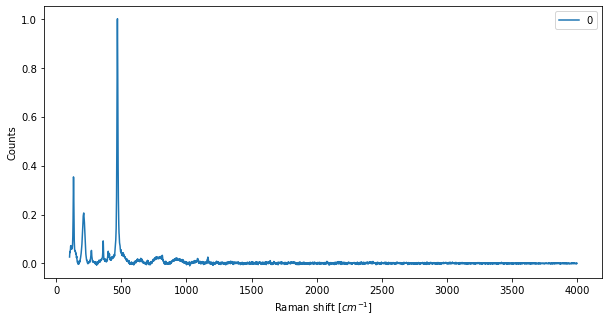

In [4]:
S=pr.type2spectra('txt3')
S=pr.bkg_subtraction(S,sigma=100,plot=False)
pr.plot(S)

# 2D similarity - basic implementation

In [6]:
shift=10
per = 0.1

lib=pr.lib()
lib_names=list(lib.keys())

match = []
names = []
step = np.linspace(0,1,5)
step = step[1:-1]
for a in range(len(lib_names)):
    for b in range(len(lib_names)):
        if b>a:
            
            N = 2
            A=pr.lib(lib_names[a]).copy()
            A[1] /=  np.max(A[1])
            B=pr.lib(lib_names[b]).copy()
            B[1] /=  np.max(B[1])
            min = np.max([A[0,0],B[0,0]])
            max = np.min([A[0,-1],B[0,-1]])
            min_A = np.where(A[0]==min)[0][0]
            max_A = np.where(A[0]==max)[0][0]
            min_B = np.where(B[0]==min)[0][0]
            max_B = np.where(B[0]==max)[0][0]
            A = A[:,min_A:max_A]
            B = B[:,min_B:max_B]

            temp=[0,0]
            for i in step:
                X = np.array([A[0,:], i*A[1,:]+(1-i)*B[1,:]])
                t = pr.cos_sim_w_shift(S,X ,shift)
                if t>temp[1]:
                    temp[1] = t
                    temp[0] = str(i)+' '+lib_names[a]+', '+str(1-i)+' '+lib_names[b]
                
            
            x1 = pr.cos_sim_w_shift(S, pr.lib(lib_names[a]),shift) # da modificare il modo
            x2 = pr.cos_sim_w_shift(S, pr.lib(lib_names[b]),shift)
            if (temp[1]>np.max([x1,x2])*(1+per)): 
                names.append(temp[0])
                match.append(temp[1])
        
        if b==a:
            B = pr.lib(lib_names[a]).copy()
            names.append(lib_names[a])
            match.append(pr.cos_sim_w_shift(S,B,shift))
            

match = pd.DataFrame({'spectra':names, 'match':match})    
match.sort_values('match', ascending=False, inplace=True)
match.reset_index(inplace=True, drop=True)
print(match.head(10))

                            spectra     match
0                            Quartz  0.952387
1          0.5 Anatase, 0.5 Zoisite  0.487428
2                            Albite  0.486081
3       0.5 Microcline, 0.5 Zoisite  0.472296
4       0.5 Orthoclase, 0.5 Zoisite  0.460807
5      0.5 Orthoclase, 0.5 Titanite  0.434150
6         0.5 Epidote, 0.5 Pimelite  0.432977
7        0.5 Pimelite, 0.5 Titanite  0.432102
8  0.75 Chalcopyrite, 0.25 Titanite  0.431098
9    0.75 Microcline, 0.25 Titanite  0.428916


In [10]:
pr.search(S,shift=10)

  alias                         name     match
0  sch0  Quartz__R060604__Raman__780  0.976377
1  sch1  Quartz__X080015__Raman__780  0.975977
2  sch2  Quartz__R050125__Raman__514  0.974004
3  sch3  Quartz__X080016__Raman__532  0.969733
4  sch4  Quartz__X080016__Raman__780  0.969478
5  sch5  Quartz__R040031__Raman__780  0.967256
6  sch6  Quartz__R050125__Raman__780  0.966819
7  sch7  Quartz__X080015__Raman__532  0.965818
8  sch8  Quartz__R040031__Raman__514  0.964360
9  sch9  Quartz__R060604__Raman__532  0.960636


In [ ]:
A = pr.lib('Albite')
B = pr.lib('Muscovite')
C = pr.type2spectra('sch0')

pr.plot([S,A,B,C])

# 1D similarity - looking for smarter implementation (failed)

In [46]:
lib=pr.lib()
lib_names=list(lib.keys())

########### putting the library in a np.array ###########
m = len(lib_names)

# searching the minimum and the maximum wn of the library
min = lib[lib_names[0]][0].min()
max = lib[lib_names[0]][0].max()

for el in lib_names[1:]:
    min_t = lib[el][0].min()
    max_t = lib[el][0].max()

    if min_t<min:
        min = min_t
    if max_t>max:
        max = max_t

wn = np.arange(min,max+1)
n = len(wn)

# rewriting the library in a np.array
LIB = np.zeros((m,n))*np.nan

for i in range(len(lib_names)):
    min_t = lib[lib_names[i]][0].min()
    max_t = lib[lib_names[i]][0].max()
    
    LIB[i][int(min_t-min):n-int(max-max_t)]  = lib[lib_names[i]][1]

In [51]:
shift = 10
cos_sim = []
for i in np.arange(-shift,shift+1):
    ########### reshaping with respect with the spectrum S ###########
    LIB.shape[0]

    # ausiliary variables
    S_temp = copy.deepcopy(S)
    S_temp[0] += i
    LIB_temp = copy.deepcopy(LIB)
    wn_temp = copy.deepcopy(wn)

    # chanching dimensions
    min_1 = np.min(S_temp[0])
    min_2 = np.min(wn_temp)

    if min_1<min_2:
        S_temp = S_temp[int(min_2-min_1):]
    if min_2<min_1:
        wn_temp = wn_temp[int(min_1-min_2):]
        LIB_temp = LIB_temp[:,int(min_1-min_2):]

    max_1 = np.max(S_temp[0])
    max_2 = np.max(wn_temp)

    if max_1>max_2:
        S_temp = S_temp[:,:int(max_2-max_1)]
    if max_2>max_1:
        wn_temp = wn_temp[:int(max_1-max_2)]
        LIB_temp = LIB_temp[:,:int(max_1-max_2)]

    ########## computing the cosine similarity ##########

    # upper term
    LIB_temp_wones = np.nan_to_num(LIB_temp)
    D = np.dot(LIB_temp_wones,S_temp[1])

    # library norm
    N1 = np.sum(LIB_temp_wones**2,axis=1)

    #spectrum norm
    N2 = np.dot( np.nan_to_num(np.zeros(LIB_temp.shape)*LIB_temp+1), S_temp[1]**2)

    cos_sim.append(D/(np.sqrt(N1)*np.sqrt(N2)))
    
#cos_sim = np.max(cos_sim)


# 2D search: looking for a smarter implementation

In [5]:
lib=pr.lib()
lib_names=list(lib.keys())

########### putting the library in a np.array ###########
m = len(lib_names)

# searching the minimum and the maximum wn of the library
min = lib[lib_names[0]][0].min()
max = lib[lib_names[0]][0].max()

for el in lib_names[1:]:
    min_t = lib[el][0].min()
    max_t = lib[el][0].max()

    if min_t<min:
        min = min_t
    if max_t>max:
        max = max_t

wn = np.arange(min,max+1)
n = len(wn)

# rewriting the library in a np.array
LIB = np.zeros((m,n))

for i in range(len(lib_names)):
    min_t = lib[lib_names[i]][0].min()
    max_t = lib[lib_names[i]][0].max()
    
    LIB[i][int(min_t-min):n-int(max-max_t)]  = lib[lib_names[i]][1]

# rescaling the height to 1
LIB = (LIB.transpose()/LIB.max(axis=1)).transpose()

In [9]:
# ausiliar variables
LIB_temp = copy.deepcopy(LIB)
S_temp = copy.deepcopy(S)
S_temp[1] = S_temp[1]/S_temp[1].max()
wn_temp = copy.deepcopy(wn)

# chanching dimensions of LIB_temp or S_temp
min_1 = np.min(S_temp[0])
min_2 = np.min(wn_temp)

if min_1<min_2:
    S_temp = S_temp[int(min_2-min_1):]
if min_2<min_1:
    wn_temp = wn_temp[int(min_1-min_2):]
    LIB_temp = LIB_temp[:,int(min_1-min_2):]

max_1 = np.max(S_temp[0])
max_2 = np.max(wn_temp)

if max_1>max_2:
    S_temp = S_temp[:,:int(max_2-max_1)]
if max_2>max_1:
    wn_temp = wn_temp[:int(max_1-max_2)]
    LIB_temp = LIB_temp[:,:int(max_1-max_2)]

# generate shifted spectrum

shift = 10

shift_vec = np.arange(-shift,shift+1)

LIB_temp_shifted = np.zeros((LIB_temp.shape[0]*len(shift_vec),LIB_temp.shape[1]))

for i in range(len(shift_vec)):
    if shift_vec[i]>0:
        LIB_temp_shifted[i*LIB_temp.shape[0]:(i+1)*LIB_temp.shape[0],int(shift_vec[i]):] = LIB_temp[:,:-int(shift_vec[i])]
    if shift_vec[i]<0:
        LIB_temp_shifted[i*LIB_temp.shape[0]:(i+1)*LIB_temp.shape[0],:int(shift_vec[i])] = LIB_temp[:,-int(shift_vec[i]):]
    if shift_vec[i]==0:
        LIB_temp_shifted[i*LIB_temp.shape[0]:(i+1)*LIB_temp.shape[0],:] = LIB_temp[:,:]

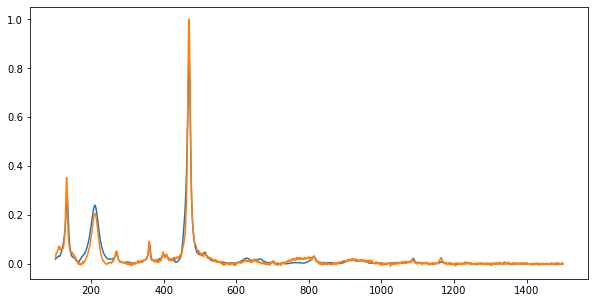

# of used spectra =  3
      name  shift  regression coefficient
0  Anatase    -10                0.156544
1   Quartz      6                0.626106
2   Quartz      7                0.210201


In [18]:
# linear regression
reg = LinearRegression(fit_intercept=False, positive=True, n_jobs=-1)
reg.fit(LIB_temp_shifted.transpose(),S_temp[1])

# plot the regression
plt.figure(figsize=(10,5))
plt.plot(wn_temp,np.dot(LIB_temp_shifted.transpose(),reg.coef_))
plt.plot(S_temp[0],S_temp[1])
plt.show()

# number of used spectrums used, selection of really used spectra

th = 0.05

count=0
lib_used = []
for i in range(len(reg.coef_)):
    if reg.coef_[i]>th:
        count+=1
        lib_used.append(i)

print('# of used spectra = ',count)

# selected spectra sumup
sumup = []

for i in range(len(lib_used)):
    sumup.append([lib_names[lib_used[i] - LIB_temp.shape[0]*(lib_used[i]//LIB_temp.shape[0])] , shift_vec[lib_used[i]//LIB_temp.shape[0]], reg.coef_[lib_used[i]]])

sumup = pd.DataFrame(sumup, columns=['name','shift','regression coefficient'])
print(sumup)

In [17]:
N = 2
from itertools import combinations

comb = list(combinations(list(sumup.index),N))

# eliminare combinazioni dello stesso spettro shiftato!
#......................................................
#......................................................
#......................................................
#......................................................

print('trying N =', N,'; resulting in', len(comb), 'combinations')

# I need to compute the cosine similarity of the various possible combinations, and store its values

for c in range(len(comb)):
    # some needed variables
    if N>1:
        step = np.linspace(0,1,7)
        step = step[1:-1]
    if N==1:
        step = 1
    
    pure = []
    for el in comb[c]:
        # restringo i wn a quelli comuni


    




trying N = 2 ; resulting in 45 combinations


In [67]:
shift=5
per = 0.1

match = []
names = []
step = np.linspace(0,1,7)
step = step[1:-1]
for a in range(len(lib_used)):
    for b in range(len(lib_used)):
        if b>a:
            
            N = 2
            A=pr.lib(lib_used[a]).copy()
            A[1] /=  np.max(A[1])
            B=pr.lib(lib_used[b]).copy()
            B[1] /=  np.max(B[1])
            min = np.max([A[0,0],B[0,0]])
            max = np.min([A[0,-1],B[0,-1]])
            min_A = np.where(A[0]==min)[0][0]
            max_A = np.where(A[0]==max)[0][0]
            min_B = np.where(B[0]==min)[0][0]
            max_B = np.where(B[0]==max)[0][0]
            A = A[:,min_A:max_A]
            B = B[:,min_B:max_B]

            temp=[0,0]
            for i in step:
                X = np.array([A[0,:], i*A[1,:]+(1-i)*B[1,:]])
                t = pr.cos_sim_w_shift(S,X ,shift)
                if t>temp[1]:
                    temp[1] = t
                    temp[0] = str(i)+' '+lib_used[a]+', '+str(1-i)+' '+lib_used[b]
                
            
            x1 = pr.cos_sim_w_shift(S, pr.lib(lib_names[a]),shift) # da modificare il modo
            x2 = pr.cos_sim_w_shift(S, pr.lib(lib_names[b]),shift)
            if (temp[1]>np.max([x1,x2])*(1+per)): 
                names.append(temp[0])
                match.append(temp[1])
        
        if b==a:
            B = pr.lib(lib_names[a]).copy()
            names.append(lib_names[a])
            match.append(pr.cos_sim_w_shift(S,B,shift))
            

match = pd.DataFrame({'spectra':names, 'match':match})    
match.sort_values('match', ascending=False, inplace=True)
match.reset_index(inplace=True, drop=True)
print(match.head(10))

                                             spectra     match
0  0.8333333333333333 Quartz__X080016__Raman__780...  0.982013
1  0.8333333333333333 Quartz__X080016__Raman__780...  0.978760
2  0.16666666666666666 Calcite__R050128__Raman__5...  0.977340
3  0.16666666666666666 Covellite__R060143__Raman_...  0.976461
4  0.8333333333333333 Quartz__X080016__Raman__780...  0.971312
5  0.8333333333333333 Quartz__X080016__Raman__780...  0.970513
6  0.8333333333333333 Diamond__R050207__Raman__53...  0.969652
7  0.16666666666666666 Bertrandite__R060800__Rama...  0.969563
8  0.8333333333333333 Quartz__X080016__Raman__780...  0.969373
9  0.16666666666666666 Nahcolite__R070237__Raman_...  0.967684
